# GEONE - Substitution Random Functions (SRF) - continuous random fields

A substitution random function is a function $Z=Y(T)$, where $T$ is the **directing function** (latent field) and $Y$ the **coding process**.

The directing function $T$ is a random process, $T: \mathbb{R}^d \longrightarrow  \mathbb{R}$, and the coding process a random process, $Y:\mathbb{R}\longrightarrow \mathbb{R}$.

- The directing function and the coding process are independent.
- The directing function has stationary increment.
- The coding process is stationary.

In this notebook, we consider SRF with 

- multiGaussian latent field $T$
- multiGaussian random process (1D) as coding process $Y$

Illustrations are given for unconditional and conditional cases, in 1D, 2D, and 3D.

*Additional example.* See also at the end of the notebook: an example or SRF based on two latent fields, i.e. 
a directing function $T=(T_1, T_2)$, where $T_1, T_2: \mathbb{R}^d \longrightarrow  \mathbb{R}$, are multiGaussian fields and a 2D multiGausian field as coding process, $Y:\mathbb{R^2}\longrightarrow \mathbb{R}$. The processes $T_1, T_2$ and $Y$ are independent, and $Z=Y(T)= Y(T_1, T_2)$.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from matplotlib.gridspec import GridSpec

import pyvista as pv

# import from package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Function `geone.srf.srf_mg_mg`

This function allows to generate continuous realizations in 1D, 2D and 3D (see examples below) of SRF with multiGaussian latent field and multiGaussian random process as coding process. Conditional and unconditional simulations can be done. For conditional simulation, a kind of Metropolis-Hasting algorithm is used (see help of the function); if conditioning fails, it is possible to get less realizations than the specified number (warning is displayed depending on the `verbose` keyword argument). Moreover, control point(s) on the coding process can be added, typically imposing the value of $Y$ at the mean of $T$.

In full output mode (keyword argument `full_output=True` (default)), in addition to the resulting $Z$ fields, are retrieved in output: the latent fields ($T$) and the 1D field ($Y$) of all realizations.

## Example : conditional 1D SRF

In [4]:
# Parameters for display (used further)
im_T_display={'cmap':'gist_ncar'}
im_Z_display={'cmap':'terrain'}

In [5]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 1,   1    # number of cells
sx, sy, sz = 0.5, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T (latent field)
# -------------------------------------
r_T = 15.0
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel1D(elem=[
    ('matern', {'w':w_T, 'r':gn.covModel.cov_matern_get_r_param(nu_T, r_T), 'nu':nu_T}),
    ], name='cov_model_T')

# Mean of T
mean_T = 0.0

# Covariance model for Y
# ----------------------
nu_Y = 3 # matern covariance with nu=3 is close to Gaussian covariance
r_Y = 2.0*np.sqrt(w_T)
w_Y = 4.0
cov_model_Y = gn.covModel.CovModel1D(elem=[
        ('matern', {'w':w_Y, 'r':gn.covModel.cov_matern_get_r_param(nu_Y, r_Y), 'nu':nu_Y}),
        ], name='')
cov_Y_0 = cov_model_Y.func()([0.])[0]  # sill (w_Y)
std_Y_0 = np.sqrt(cov_Y_0)

mean_Y = -3.0 # Mean of Y 

# 1D-grid resolution for Y (coding process)
spacing_Y=.0001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([17.25, 27.25, 54.25, 66.25, 75.25])
v = np.array([-5. , -3., -1., -4., -1.])

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Target distribution
target_distrib = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, nx, sx, ox,
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    target_distrib=target_distrib,
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


srf_mg_mg: simulation 1 of 3...
srf_mg_mg:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mg:   ... sim 1 of 3

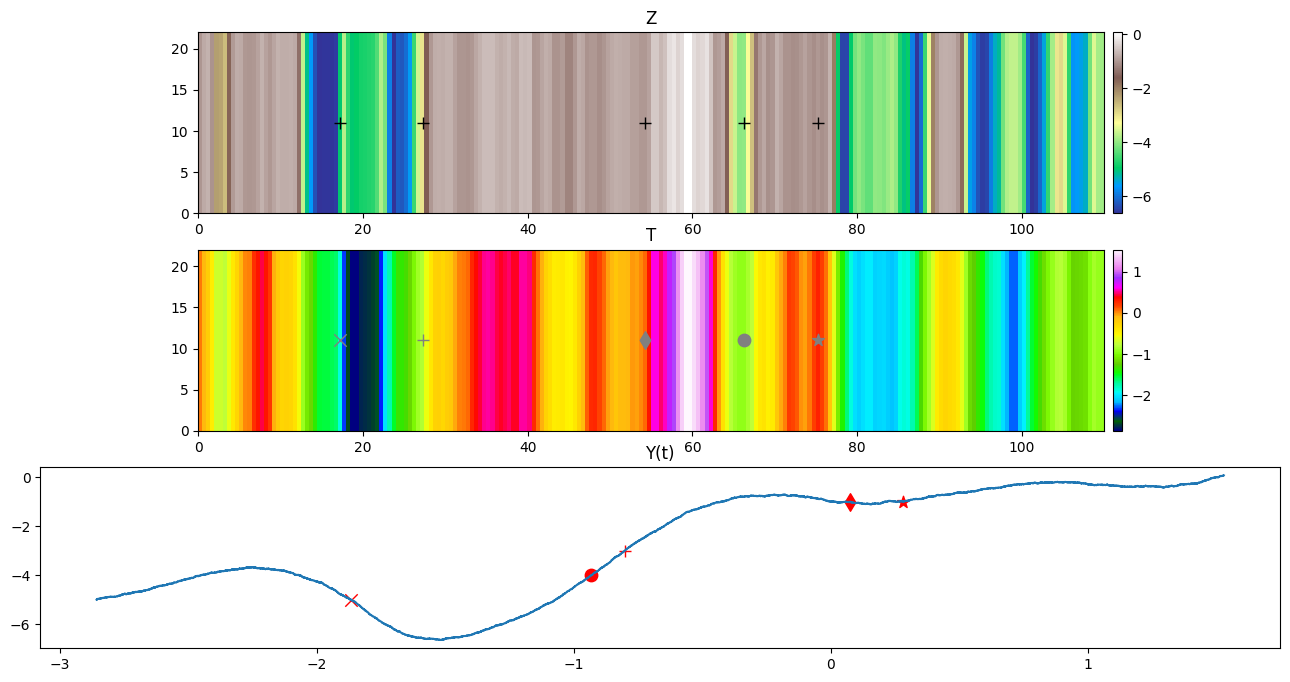

In [6]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_T.sy = .2 * im_T.sx*im_T.nx 
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

plt.subplots(3, 1, figsize=(16, 8))

# Z
plt.subplot(3,1,1)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    yc = im_Z.oy+0.5*im_Z.sy
    plt.scatter(x, yc*np.ones_like(x), marker='+', s=80, color='black', linewidths=1)

plt.title('Z')

# T
plt.subplot(3,1,2)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x, yc*np.ones_like(x), 'rx', markersize=20)
    for i in range(len(x)):
        plt.scatter(x[i], yc, marker=marker_loc[i%len(marker_loc)], s=80, color='grey', linewidths=1)

plt.title('T')

# Y
plt.subplot(3,1,3)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:]-im_T.ox)/im_T.sx # (x[:,0]-im_T.oy)/im_T.sy
    jy = np.zeros(x.shape[0])   # (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

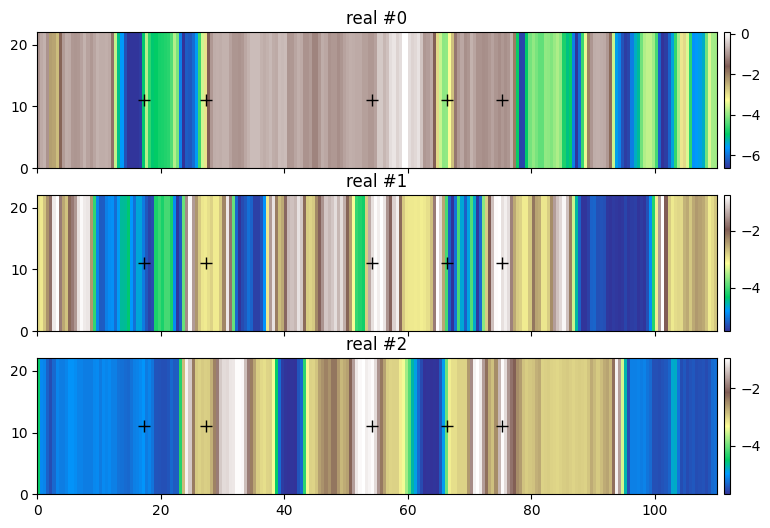

In [7]:
# Plot 3 realizations of Z
plt.subplots(3,1, sharex=True, sharey=True, figsize=(15,6))
plt.subplot(3,1,1)
for j in range(3):
    plt.subplot(3,1,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        yc = im_Z.oy+0.5*im_Z.sy
        plt.scatter(x, yc*np.ones_like(x), marker='+', s=80, color='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [8]:
# Number of realizations and seed
nreal = 100
seed_sim = 232

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, nx, sx, ox,
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    nreal=nreal,
    full_output=False,
    verbose=2
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')


srf_mg_mg: simulation 1 of 100...
srf_mg_mg: simulation 2 of 100...
srf_mg_mg: simulation 3 of 100...
srf_mg_mg: simulation 4 of 100...
srf_mg_mg: simulation 5 of 100...
srf_mg_mg: simulation 6 of 100...
srf_mg_mg: simulation 7 of 100...
srf_mg_mg: simulation 8 of 100...
srf_mg_mg: simulation 9 of 100...
srf_mg_mg: simulation 10 of 100...
srf_mg_mg: simulation 11 of 100...
srf_mg_mg: simulation 12 of 100...
srf_mg_mg: simulation 13 of 100...
srf_mg_mg: WARNING: conditioning points for Y falling in a same grid cell have been aggregated (mean) (real index 12)
srf_mg_mg: simulation 14 of 100...
srf_mg_mg: simulation 15 of 100...
srf_mg_mg: simulation 16 of 100...
srf_mg_mg: simulation 17 of 100...
srf_mg_mg: simulation 18 of 100...
srf_mg_mg: simulation 19 of 100...
srf_mg_mg: simulation 20 of 100...
srf_mg_mg: simulation 21 of 100...
srf_mg_mg: simulation 22 of 100...
srf_mg_mg: simulation 23 of 100...
srf_mg_mg: simulation 24 of 100...
srf_mg_mg: simulation 25 of 100...
srf_mg_mg: simul

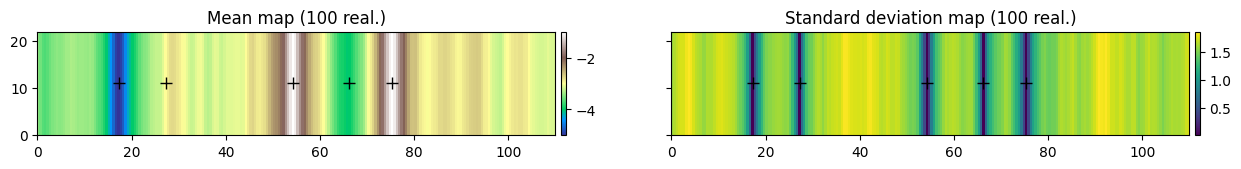

In [9]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Statistics (proportion map)
# ---------------------------
im_Z_mean = gn.img.imageContStat(im_Z, op='mean')
im_Z_std  = gn.img.imageContStat(im_Z, op='std')

# Plot
# ----
plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_Z_mean, **im_Z_display)
plt.title(f'Mean map ({im_Z.nv} real.)')
if x is not None:
    yc = im_Z.oy+0.5*im_Z.sy
    plt.scatter(x, yc*np.ones_like(x), marker='+', s=80, color='black', linewidths=1)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_Z_std, cmap='viridis')
plt.title(f'Standard deviation map ({im_Z.nv} real.)')
if x is not None:
    yc = im_Z.oy+0.5*im_Z.sy
    plt.scatter(x, yc*np.ones_like(x), marker='+', s=80, color='black', linewidths=1)

plt.show()

## Example : conditional 2D SRF

In [10]:
# Parameters for display (used further)
im_T_display={'cmap':'gist_ncar'}
im_Z_display={'cmap':'terrain'}

In [11]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T (latent field)
# -------------------------------------
r_T = 1.0*np.array([25.0, 25.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Covariance model for Y
# ----------------------
nu_Y = 3 # matern covariance with nu=3 is close to Gaussian covariance
r_Y = 2.0*np.sqrt(w_T)
w_Y = 4.0
cov_model_Y = gn.covModel.CovModel1D(elem=[
        ('matern', {'w':w_Y, 'r':gn.covModel.cov_matern_get_r_param(nu_Y, r_Y), 'nu':nu_Y}),
        ], name='')
cov_Y_0 = cov_model_Y.func()([0.])[0]  # sill (w_Y)
std_Y_0 = np.sqrt(cov_Y_0)

mean_Y = -3.0 # Mean of Y 

# 1D-grid resolution for Y (coding process)
spacing_Y=.0001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
# Conditioning data
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([-5. , -5., -3., -1., -1.])
#np.random.seed(123)
#nhd = 30
#x = np.array((ox + np.random.random(nhd)*nx*sx, oy + np.random.random(nhd)*ny*sy)).T
#v = np.random.choice(categVal, replace=True, size=nhd)
#v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Target distribution
target_distrib = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    target_distrib=target_distrib,
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')

srf_mg_mg: simulation 1 of 3...
srf_mg_mg:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mg:   ... sim 1 of 3

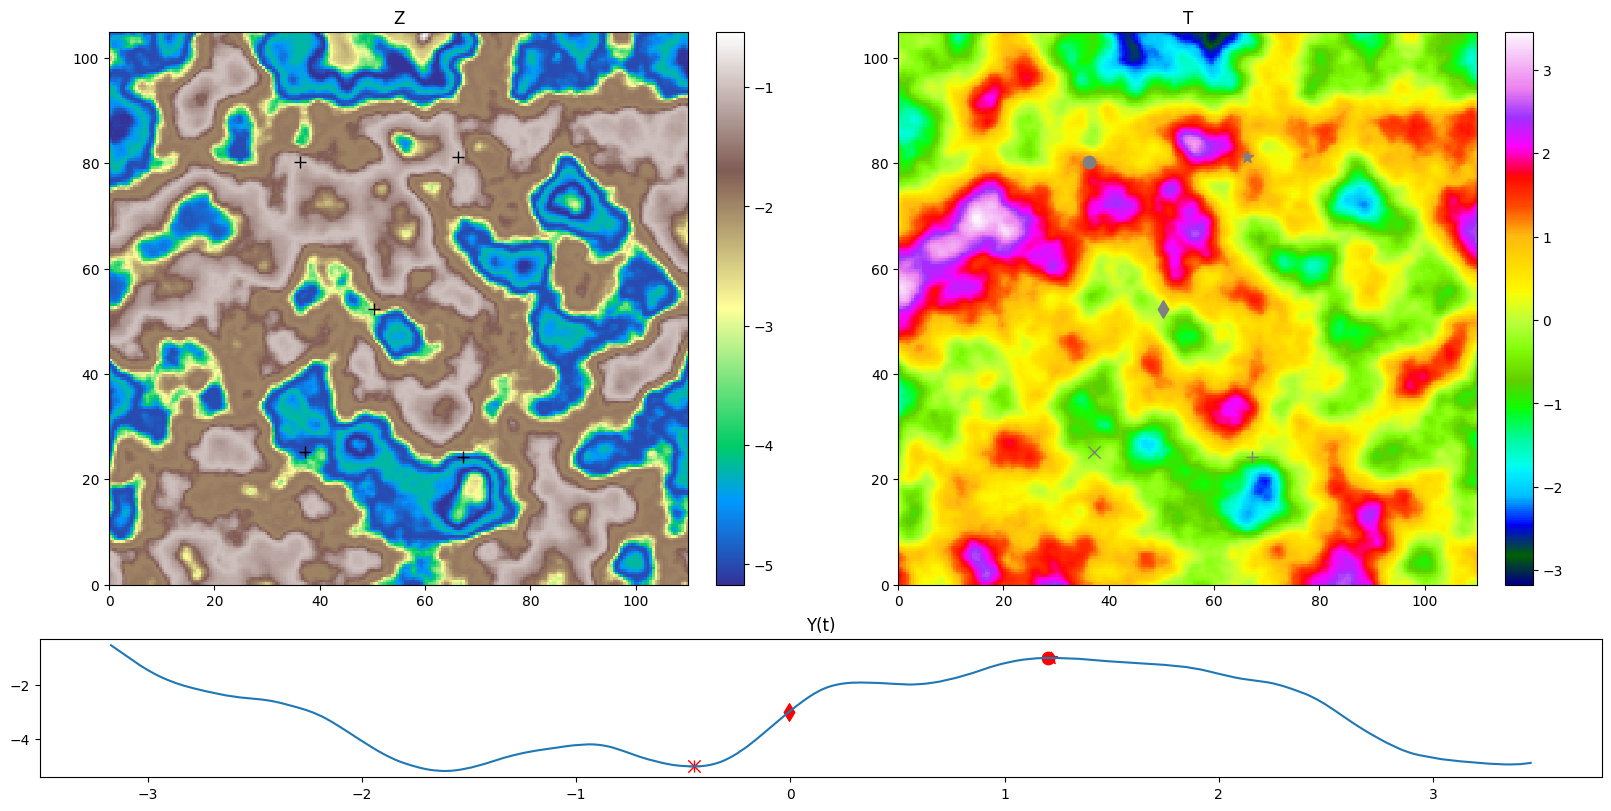

In [12]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = GridSpec(5, 4, figure=fig)
axZ = fig.add_subplot(gs[0:4, 0:2]) # ax for Z
axT = fig.add_subplot(gs[0:4, 2:4]) # ax for T
axY = fig.add_subplot(gs[4:5, 0:4]) # ax for Y

# Z
plt.sca(axZ)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.title('Z')

# T
plt.sca(axT)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], s=80, color='grey', linewidths=1)

plt.title('T')

# Y
plt.sca(axY)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

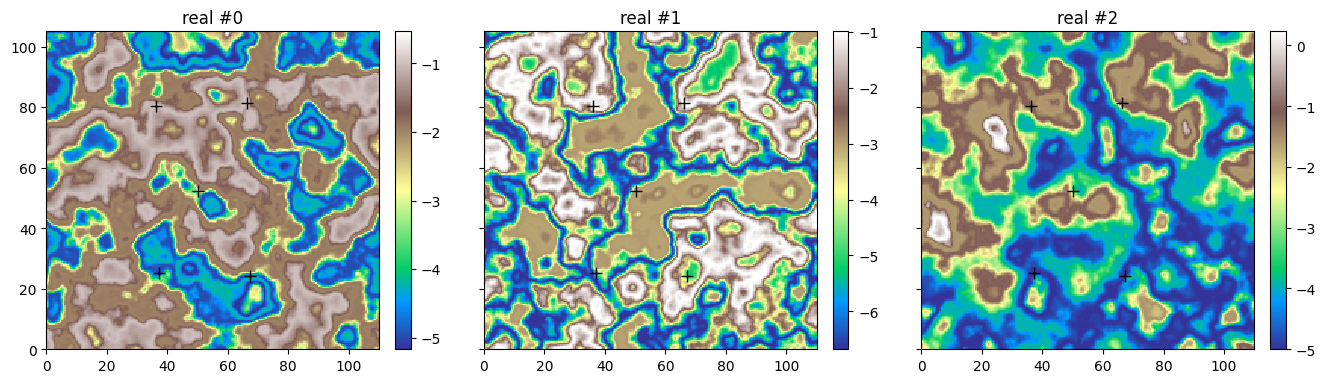

In [13]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
       plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [14]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    nreal=nreal,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')


srf_mg_mg: simulation 1 of 100...
srf_mg_mg: simulation 2 of 100...
srf_mg_mg: simulation 3 of 100...
srf_mg_mg: simulation 4 of 100...
srf_mg_mg: simulation 5 of 100...
srf_mg_mg: simulation 6 of 100...
srf_mg_mg: simulation 7 of 100...
srf_mg_mg: simulation 8 of 100...
srf_mg_mg: simulation 9 of 100...
srf_mg_mg: simulation 10 of 100...
srf_mg_mg: simulation 11 of 100...
srf_mg_mg: simulation 12 of 100...
srf_mg_mg: simulation 13 of 100...
srf_mg_mg: simulation 14 of 100...
srf_mg_mg: simulation 15 of 100...
srf_mg_mg: simulation 16 of 100...
srf_mg_mg: simulation 17 of 100...
srf_mg_mg: simulation 18 of 100...
srf_mg_mg: simulation 19 of 100...
srf_mg_mg: simulation 20 of 100...
srf_mg_mg: simulation 21 of 100...
srf_mg_mg: simulation 22 of 100...
srf_mg_mg: simulation 23 of 100...
srf_mg_mg: simulation 24 of 100...
srf_mg_mg: simulation 25 of 100...
srf_mg_mg: simulation 26 of 100...
srf_mg_mg: simulation 27 of 100...
srf_mg_mg: simulation 28 of 100...
srf_mg_mg: simulation 29 of 1

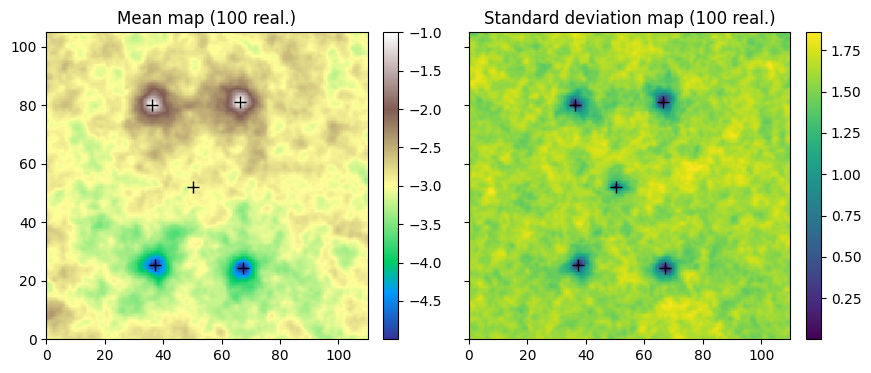

In [15]:
# Statistics (proportion map)
# ---------------------------
im_Z_mean = gn.img.imageContStat(im_Z, op='mean')
im_Z_std  = gn.img.imageContStat(im_Z, op='std')

# Plot
# ----
plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_Z_mean, **im_Z_display)
plt.title(f'Mean map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_Z_std, cmap='viridis')
plt.title(f'Standard deviation map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.show()

## Example : conditional 2D SRF with control point: Y(mean_T) imposed

As in the latent field $T$ the area with value close to the mean is well connected, imposing $Y(mean\_T) = y_0$ as additional contraint on the coding process implies that the area with value close to $y_0$ will be well connected in the resulting SRF $Z$.

In [16]:
# Parameters for display (used further)
im_T_display={'cmap':'gist_ncar'}
im_Z_display={'cmap':'terrain'}

In [17]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T = 1.0*np.array([25.0, 25.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Covariance model for Y
# ----------------------
nu_Y = 3 # matern covariance with nu=3 is close to Gaussian covariance
r_Y = 2.0*np.sqrt(w_T)
w_Y = 4.0
cov_model_Y = gn.covModel.CovModel1D(elem=[
        ('matern', {'w':w_Y, 'r':gn.covModel.cov_matern_get_r_param(nu_Y, r_Y), 'nu':nu_Y}),
        ], name='')
cov_Y_0 = cov_model_Y.func()([0.])[0]  # sill (w_Y)
std_Y_0 = np.sqrt(cov_Y_0)

mean_Y = -3.0 # Mean of Y 

# 1D-grid resolution for Y (coding process)
spacing_Y=.0001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
# Conditioning data
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([-5. , -5., -3., -1., -1.])
#np.random.seed(123)
#nhd = 30
#x = np.array((ox + np.random.random(nhd)*nx*sx, oy + np.random.random(nhd)*ny*sy)).T
#v = np.random.choice(categVal, replace=True, size=nhd)
#v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)

# Additional constraint on Y (control points)
t_constraint = mean_T
yt_constraint = mean_Y + 1.2 * std_Y_0 # high value

# Target distribution
target_distrib = None

# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    target_distrib=target_distrib,
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')

srf_mg_mg: simulation 1 of 3...
srf_mg_mg:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mg:   ... sim 1 of 3

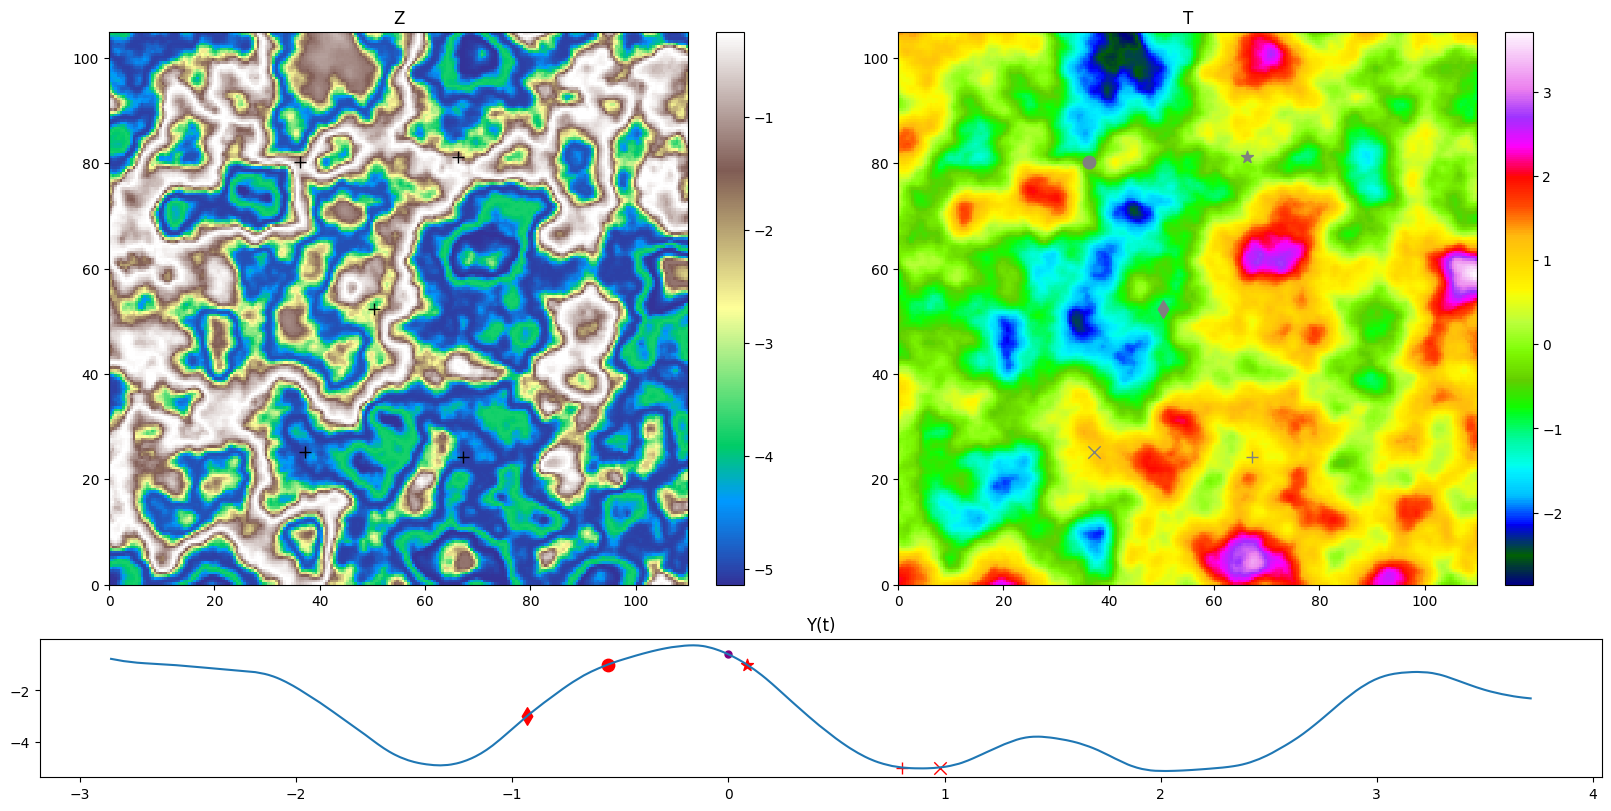

In [18]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

fig = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = GridSpec(5, 4, figure=fig)
axZ = fig.add_subplot(gs[0:4, 0:2]) # ax for Z
axT = fig.add_subplot(gs[0:4, 2:4]) # ax for T
axY = fig.add_subplot(gs[4:5, 0:4]) # ax for Y

# Z
plt.sca(axZ)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.title('Z')

# T
plt.sca(axT)
gn.imgplot.drawImage2D(im_T, iv=ireal, **im_T_display)
# Add conditioning location
if x is not None:
    yc = im_T.oy+0.5*im_T.sy
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], s=80, color='grey', linewidths=1)

plt.title('T')

# Y
plt.sca(axY)

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = np.zeros(x.shape[0])   # (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()

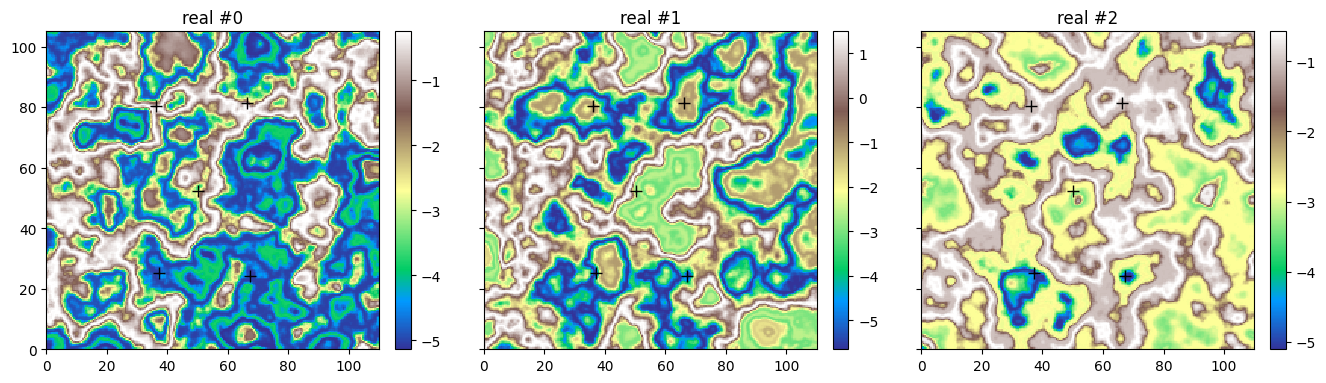

In [19]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
       plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 100 realizations (same setup)

In [20]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    nreal=nreal,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')


srf_mg_mg: simulation 1 of 100...
srf_mg_mg: simulation 2 of 100...
srf_mg_mg: simulation 3 of 100...
srf_mg_mg: simulation 4 of 100...
srf_mg_mg: WARNING: conditioning points for Y falling in a same grid cell have been aggregated (mean) (real index 3)
srf_mg_mg: simulation 5 of 100...
srf_mg_mg: simulation 6 of 100...
srf_mg_mg: simulation 7 of 100...
srf_mg_mg: simulation 8 of 100...
srf_mg_mg: simulation 9 of 100...
srf_mg_mg: simulation 10 of 100...
srf_mg_mg: simulation 11 of 100...
srf_mg_mg: simulation 12 of 100...
srf_mg_mg: simulation 13 of 100...
srf_mg_mg: simulation 14 of 100...
srf_mg_mg: simulation 15 of 100...
srf_mg_mg: simulation 16 of 100...
srf_mg_mg: simulation 17 of 100...
srf_mg_mg: simulation 18 of 100...
srf_mg_mg: simulation 19 of 100...
srf_mg_mg: simulation 20 of 100...
srf_mg_mg: simulation 21 of 100...
srf_mg_mg: simulation 22 of 100...
srf_mg_mg: simulation 23 of 100...
srf_mg_mg: simulation 24 of 100...
srf_mg_mg: simulation 25 of 100...
srf_mg_mg: simula

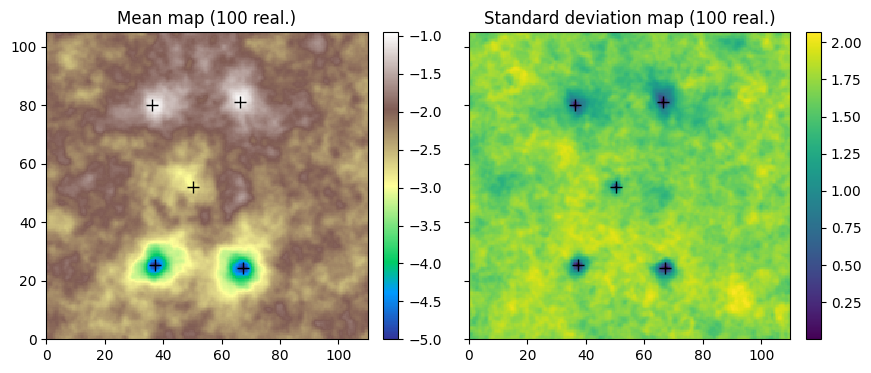

In [21]:
# Statistics (proportion map)
# ---------------------------
im_Z_mean = gn.img.imageContStat(im_Z, op='mean')
im_Z_std  = gn.img.imageContStat(im_Z, op='std')

# Plot
# ----
plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_Z_mean, **im_Z_display)
plt.title(f'Mean map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_Z_std, cmap='viridis')
plt.title(f'Standard deviation map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.show()

## Example : conditional 3D SRF

In [22]:
# Parameters for display (used further)
im_T_display={'cmap':'gist_ncar'}
im_Z_display={'cmap':'terrain'}

In [23]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 120, 110, 55     # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T (latent field)
# -------------------------------------
r_T = 1.0*np.array([20.0, 15.0, 10.0])
w_T = 1.0
nu_T = 1.5
cov_model_T = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T, r) for r in r_T]), 'nu':nu_T}),
    ], alpha=0.0, name='cov_model_T')

# Mean of T
mean_T = 0.0

# Covariance model for Y
# ----------------------
nu_Y = 3 # matern covariance with nu=3 is close to Gaussian covariance
r_Y = 2.0*np.sqrt(w_T)
w_Y = 4.0
cov_model_Y = gn.covModel.CovModel1D(elem=[
        ('matern', {'w':w_Y, 'r':gn.covModel.cov_matern_get_r_param(nu_Y, r_Y), 'nu':nu_Y}),
        ], name='')
cov_Y_0 = cov_model_Y.func()([0.])[0]  # sill (w_Y)
std_Y_0 = np.sqrt(cov_Y_0)

mean_Y = -3.0 # Mean of Y 

# 1D-grid resolution for Y (coding process)
spacing_Y=.00001

# SRF simulation (Z = Y(T))
# -------------------------
# ----- Parameters -----
# Conditioning data
x = np.array([[17.25, 15.25, 15.5],
              [47.25, 14.25, 23.5],
              [31.25, 32.25, 10.5],
              [18.25, 49.25, 20.5],
              [46.25, 48.25, 40.5]])
v = np.array([-5. , -5., -3., -1., -1.])

# Additional constraint on Y (control points)
t_constraint = None
yt_constraint = None

# Target distribution
target_distrib = None
# ----------------------

# ----------------------
# Number of realizations and seed
nreal = 3
seed_sim = 232
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T, Y = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    #algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    #algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    target_distrib=target_distrib,
    mh_iter=100,
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T.shape[0], val=T)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')


srf_mg_mg: simulation 1 of 3...
srf_mg_mg:   ... sim 1 of 3: MH iter 1 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 2 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 3 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 4 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 5 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 6 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 7 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 8 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 9 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 10 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 11 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 12 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 13 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 14 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 15 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 16 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 17 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 18 of 100...
srf_mg_mg:   ... sim 1 of 3: MH iter 19 of 100...
srf_mg_mg:   ... sim 1 of 3

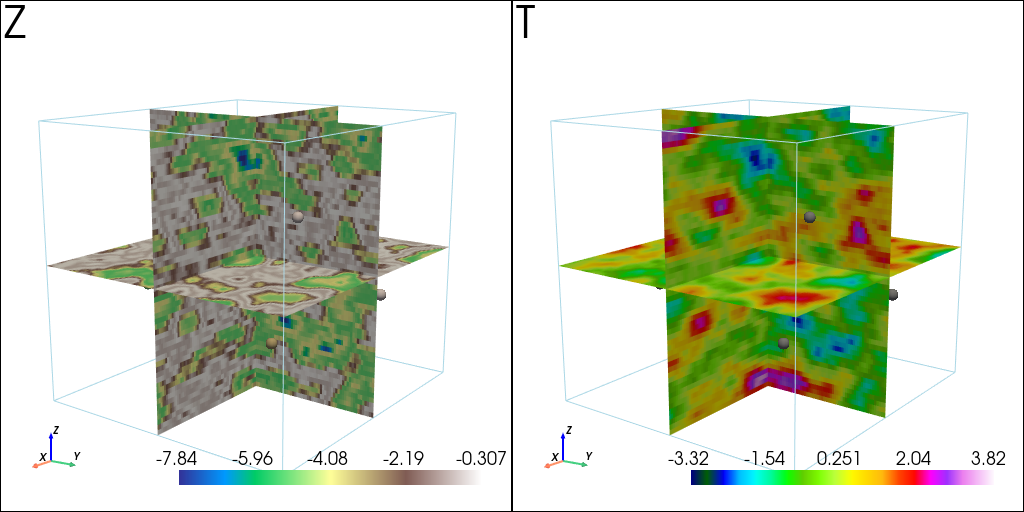

In [24]:
# Plot Z and T for one real
# -------------------------
ireal = 0 # index of the realization

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)

    # ... set color for data points according to their value
    cmap = plt.get_cmap(im_Z_display['cmap']) # color map
    cmin = im_Z.val[ireal].min()
    cmax = im_Z.val[ireal].max()
    data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
    data_points['colors'] = data_points_col

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    im_Z, 
    plotter=pp, cmin=cmin, cmax=cmax,
    slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
    slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
    slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
    **im_Z_display, 
    text='Z',
    scalar_bar_kwargs={'title':'', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_T, 
    plotter=pp,
    slice_normal_x=im_T.ox+0.5*im_T.nx*im_T.sx,
    slice_normal_y=im_T.oy+0.5*im_T.ny*im_T.sy,
    slice_normal_z=im_T.oz+0.5*im_T.nz*im_T.sz,
    **im_T_display,
    text='T',
    scalar_bar_kwargs={'title':' ', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, color='grey', point_size=12., render_points_as_spheres=True)
# note: distinct title for scalar bar, so that it will be displayed!

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

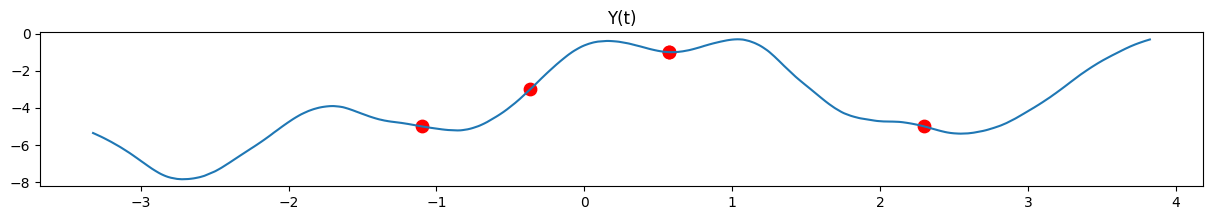

In [25]:
# Plot Y(t)
# ---------
plt.figure(figsize=(15, 2))

Y_nx = Y[ireal][0]
Y_sx = Y[ireal][1]
Y_ox = Y[ireal][2]
Y_val = Y[ireal][3]
y_abscissa = Y_ox + (np.arange(Y_nx)+0.5)*Y_sx
plt.plot(y_abscissa, Y_val)

# Add conditioning location
if x is not None:
    jx = (x[:,0]-im_T.oy)/im_T.sy
    jy = (x[:,1]-im_T.oy)/im_T.sy
    jz = (x[:,2]-im_T.oz)/im_T.sz

    ix = [int(a) for a in jx]
    iy = [int(a) for a in jy]
    iz = [int(a) for a in jz]

    # round to lower index if between two grid nodes
    ix = [a-1 if a == b and a > 0 else a for a, b in zip(ix, jx)]
    iy = [a-1 if a == b and a > 0 else a for a, b in zip(iy, jy)]
    iz = [a-1 if a == b and a > 0 else a for a, b in zip(iz, jz)]

    for i, (ixx, iyy, izz) in enumerate(zip(ix, iy, iz)):
        plt.scatter(im_T.val[ireal, izz, iyy, ixx], v[i], marker='o', color='red', s=80, linewidths=1)

# Add control point
if t_constraint is not None:
    plt.scatter(t_constraint, yt_constraint, marker='.', color='purple', s=100)

plt.title('Y(t)')

plt.show()


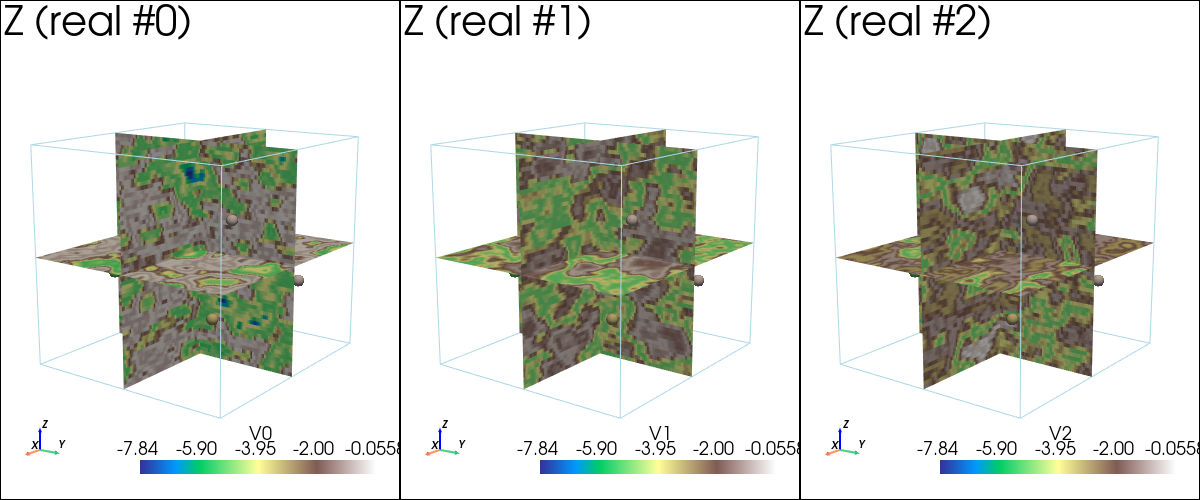

In [26]:
# Plot 3 realizations of Z

# ... set color for data points according to their value
cmap = plt.get_cmap(im_Z_display['cmap']) # color map
cmin = im_Z.val.min() # min hard data value
cmax = im_Z.val.max() # max hard data value
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col


# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,3), window_size=(1200, 500), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,3), window_size=(1200, 500))

for ireal in range(3):
    pp.subplot(0, ireal)
    gn.imgplot3d.drawImage3D_slice(im_Z, iv=ireal, plotter=pp, cmin=cmin, cmax=cmax,
                                   slice_normal_x = ox + 0.5*sx*nx,
                                   slice_normal_y = oy + 0.5*sy*ny,
                                   slice_normal_z = oz + 0.5*sz*nz,
                                   **im_Z_display, text=f'Z (real #{ireal})')

    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

### 20 realizations (same setup)

In [27]:
# Number of realizations and seed
nreal = 20
seed_sim = 232

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_mg_mg(
    cov_model_T, cov_model_Y, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T='fft', params_T={'mean':mean_T},
    algo_Y='fft', params_Y={'mean':mean_Y},
    # algo_T='classic', params_T={'mean':mean_T, 'nneighborMax':24}, # alternative algo for T
    # algo_Y='classic', params_Y={'mean':mean_Y, 'nneighborMax':12}, # alternative algo for Y
    target_distrib=target_distrib,
    nreal=nreal,
    full_output=False,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')


srf_mg_mg: simulation 1 of 20...
srf_mg_mg:   ... sim 1 of 20: MH iter 1 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 2 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 3 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 4 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 5 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 6 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 7 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 8 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 9 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 10 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 11 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 12 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 13 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 14 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 15 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 16 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 17 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 18 of 100...
srf_mg_mg:   ... sim 1 of 20: MH iter 19 of 100...
srf_mg_

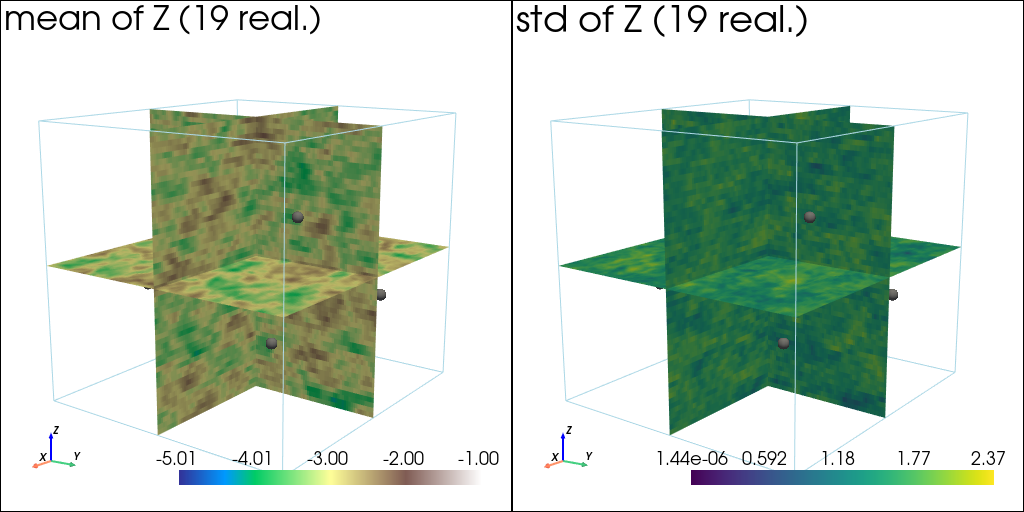

In [28]:
# Statistics (proportion map)
# ---------------------------
im_Z_mean = gn.img.imageContStat(im_Z, op='mean')
im_Z_std  = gn.img.imageContStat(im_Z, op='std')

# Plot mean and std map of all realization (Z)
# --------------------------------------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    im_Z_mean, 
    plotter=pp,
    slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
    slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
    slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
    **im_Z_display,
    text=f'mean of Z ({im_Z.nv} real.)',
    scalar_bar_kwargs={'title':'', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, color='grey', point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_Z_std, 
    plotter=pp,
    slice_normal_x=im_T.ox+0.5*im_T.nx*im_T.sx,
    slice_normal_y=im_T.oy+0.5*im_T.ny*im_T.sy,
    slice_normal_z=im_T.oz+0.5*im_T.nz*im_T.sz,
    cmap='viridis',
    text=f'std of Z ({im_Z.nv} real.)',
    scalar_bar_kwargs={'title':' ', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, color='grey', point_size=12., render_points_as_spheres=True)
# note: distinct title for scalar bar, so that it will be displayed!

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

## Additional example - SRF based on two latent fields
Here we consider the directing function $T=(T_1, T_2)$, where, $T_1, T_2: \mathbb{R}^d \longrightarrow  \mathbb{R}$, are multi-Gaussian fields and the coding process a 2D multi-Gausian field, $Y:\mathbb{R^2}\longrightarrow \mathbb{R}$. The processes $T_1, T_2$ and $Y$ are independent, and $Z=Y(T)= Y(T_1, T_2)$.

## Function `geone.srf.srf_bimg_mg`

This function allows to generate continuous realizations in 1D, 2D and 3D (see examples below) of SRF with two multiGaussian latent fields and 2D multiGaussian random process as coding process. Conditional and unconditional simulations can be done. For conditional simulation, a kind of Metropolis-Hasting algorithm is used (see help of the function); if conditioning fails, it is possible to get less realizations than the specified number (warning is displayed depending on the `verbose` keyword argument). Moreover, control point(s) on the coding process can be added, typically imposing the value of $Y$ at the mean of $(T_1, T_2)$.

In full output mode (keyword argument `full_output=True` (default)), in addition to the resulting $Z$ fields, are retrieved in output: the latent fields ($T_1, T_2$) and the 2D field ($Y$) of all realizations.

## Example in 2D

In [29]:
# Parameters for display (used further)
im_T1_display={'cmap':'gist_ncar'}
im_T2_display={'cmap':'gist_ncar'}
im_Y_display={'cmap':'rainbow'}
im_Z_display={'cmap':'terrain'}

In [30]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------------
# T1
r_T1 = 1.0*np.array([35.0, 35.0])
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T1, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T1, r) for r in r_T1]), 'nu':nu_T1}),
    ], alpha=0.0, name='cov_model_T1')
cov_T1_0 = cov_model_T1.func()([0.,0.])[0]  # sill (w_T1)
std_T1_0 = np.sqrt(cov_T1_0)

mean_T1 = 0.0 # Mean of T1

# T2 
r_T2 = 1.0*np.array([50.0, 10.0])
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T2, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T2, r) for r in r_T2]), 'nu':nu_T2}),
    ], alpha=-45.0, name='cov_model_T2')
cov_T2_0 = cov_model_T2.func()([0.,0.])[0]  # sill (w_T2)
std_T2_0 = np.sqrt(cov_T2_0)

mean_T2 = 0.0 # Mean of T2

# Covariance model for Y
# ----------------------
nu_Y = 3 # matern covariance with nu=3 is close to Gaussian covariance
r_Y = 1.0*np.array([1.5, 1.5])
w_Y = 4.0
cov_model_Y = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_Y, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_Y, r) for r in r_Y]), 'nu':nu_Y}),
    ], alpha=0.0, name='cov_model_Y')
cov_Y_0 = cov_model_Y.func()([0., 0.])[0]  # sill (w_Y)
std_Y_0 = np.sqrt(cov_Y_0)

mean_Y = -3.0 # Mean of Y

# 2D-grid resolution for Y (coding process)
# -----------------------------------------
spacing_Y=np.array([0.008, 0.008])


# SRF simulation (Z = Y(T1, T2))
# ------------------------------
# ----- Parameters -----
# Conditioning data
#x = None
#v = None
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([-5. , -5., -3., -1., -1.])

# Additional constraint on Y (control points)
#t_constraint = None
#yt_constraint = None
t_constraint = np.array([mean_T1, mean_T2])
yt_constraint = mean_Y + 1.2*std_Y_0

# Number of realizations and seed
nreal = 3
seed_sim = 134
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T1, T2, Y = gn.srf.srf_bimg_mg(
    cov_model_T1, cov_model_T2, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    algo_Y='fft', params_Y={'mean':mean_Y, 'rangeFactorForExtensionMin':2},
    nreal=nreal,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        #print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


srf_bimg_mg: simulation 1 of 3...
srf_bimg_mg:   ... sim 1 of 3: MH iter 1 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 2 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 3 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 4 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 5 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 6 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 7 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 8 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 9 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 10 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 11 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 12 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 13 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 14 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 15 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 16 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 17 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 18 of 100...
srf_bimg_mg:   ... sim 1 of 3: MH iter 

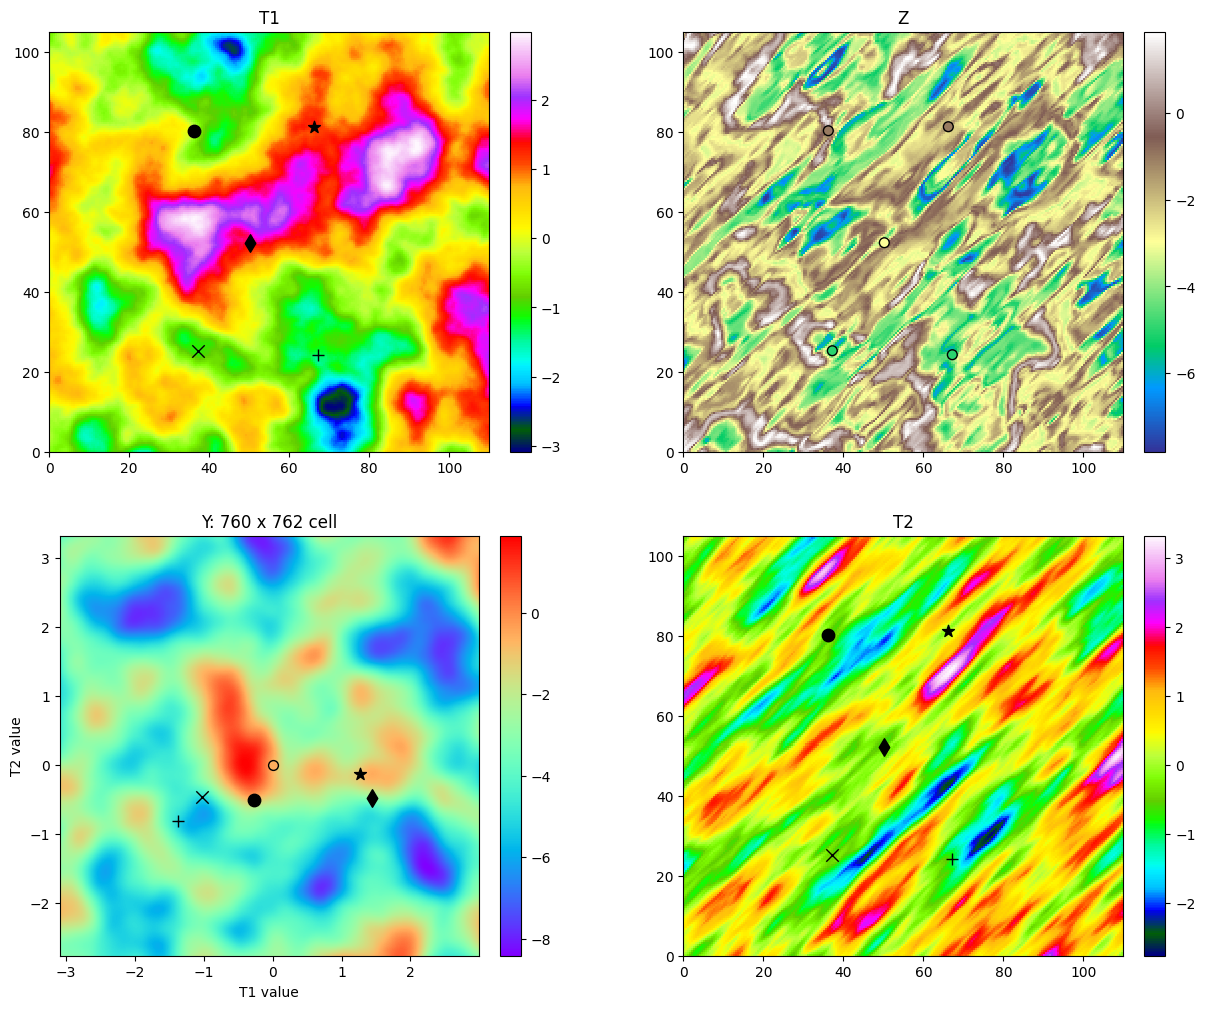

In [31]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Fill image for Y 
im_Y = gn.img.Img(*Y[ireal][0], 1, *Y[ireal][1], 1., *Y[ireal][2], 0., nv=1, val=Y[ireal][3])

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

plt.subplots(2,2, figsize=(15, 12))

# T1
plt.subplot(2,2,1)
gn.imgplot.drawImage2D(im_T1, iv=ireal, **im_T1_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='black', s=80, linewidths=1)

plt.title('T1')

# Z
plt.subplot(2,2,2)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    zmin, zmax = im_Z.val[ireal].min(), im_Y.val.max()
    cmap = plt.get_cmap(im_Z_display['cmap'])
    v_col = [cmap((vv-zmin)/(zmax-zmin)) for vv in v] # for plotting control point
    plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# Y
plt.subplot(2,2,3)
gn.imgplot.drawImage2D(im_Y, **im_Y_display)
plt.xlabel('T1 value')
plt.ylabel('T2 value')
plt.title(f'Y: {im_Y.nx} x {im_Y.ny} cell')

# Add control points
if yt_constraint is not None:
    t_constraint = np.atleast_2d(t_constraint)
    yt_constraint = np.atleast_1d(yt_constraint)
    ymin, ymax = im_Y.val.min(), im_Y.val.max()
    cmap = plt.get_cmap(im_Y_display['cmap'])
    yt_constraint_col = [cmap((yy-ymin)/(ymax-ymin)) for yy in yt_constraint] # for plotting control point
    plt.scatter(t_constraint[:,0], t_constraint[:,1], marker='o', s=50, color=yt_constraint_col, edgecolors='black', linewidths=1)

# Add conditioning location
if x is not None:
    indx, indy, indz = gn.img.pointToGridIndex(x[:,0], x[:,1], np.zeros_like(x[:,0]), sx, sy, sz, ox, oy, oz)
    y1 = np.array([im_T1.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    y2 = np.array([im_T2.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    for i in range(len(y1)):
        plt.scatter(y1[i], y2[i], marker=marker_loc[i%len(marker_loc)], color='black', s=80, linewidths=1)

# T2
plt.subplot(2,2,4)
gn.imgplot.drawImage2D(im_T2, iv=ireal, **im_T2_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='black', s=80, linewidths=1)

plt.title('T2')

plt.show()

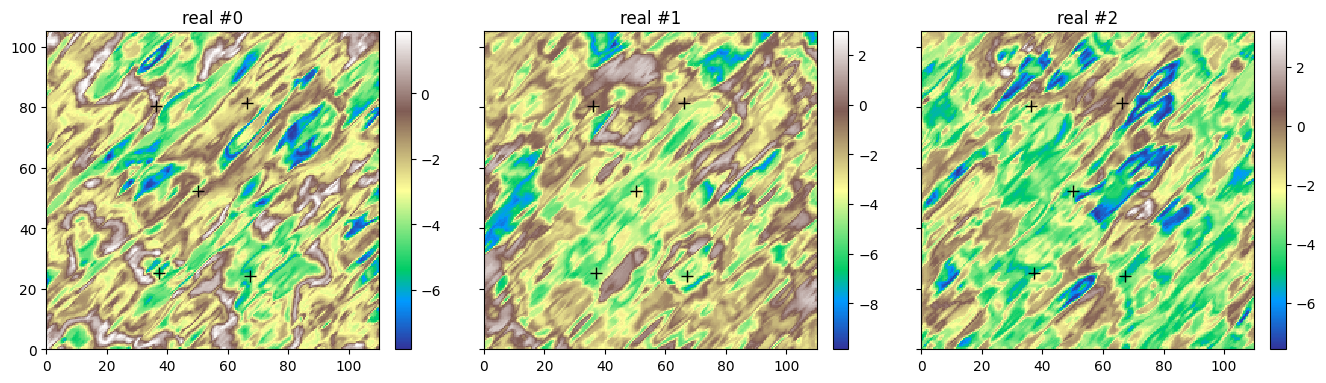

In [32]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
       plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

### 20 realizations (same setup)

In [33]:
# Number of realizations and seed
nreal = 20
seed_sim = 134

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.srf.srf_bimg_mg(
    cov_model_T1, cov_model_T2, cov_model_Y, (nx, ny), (sx, sy), (ox, oy),
    spacing_Y=spacing_Y,
    x=x, v=v,
    t=t_constraint, yt=yt_constraint,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    algo_Y='fft', params_Y={'mean':mean_Y, 'rangeFactorForExtensionMin':2},
    
    nreal=nreal,
    full_output=False,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(np.isclose(im_Z_value_at_x, v))
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        #print('Conditioning data, ok at:', 100*np.mean(np.isclose(im_Z_value_at_x, v)), '%')

srf_bimg_mg: simulation 1 of 20...
srf_bimg_mg:   ... sim 1 of 20: MH iter 1 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 2 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 3 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 4 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 5 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 6 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 7 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 8 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 9 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 10 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 11 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 12 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 13 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 14 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 15 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 16 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 17 of 100...
srf_bimg_mg:   ... sim 1 of 20: MH iter 18 of 100...
srf_bimg_mg:   ... s

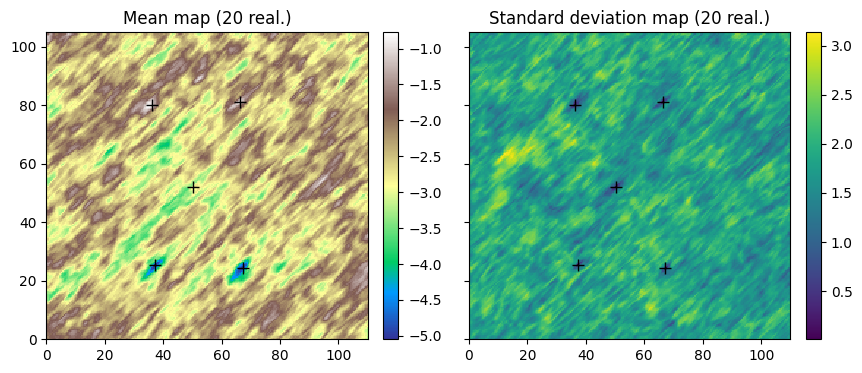

In [34]:
# Statistics (proportion map)
# ---------------------------
im_Z_mean = gn.img.imageContStat(im_Z, op='mean')
im_Z_std  = gn.img.imageContStat(im_Z, op='std')

# Plot
# ----
plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_Z_mean, **im_Z_display)
plt.title(f'Mean map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_Z_std, cmap='viridis')
plt.title(f'Standard deviation map ({im_Z.nv} real.)')
if x is not None:
   plt.scatter(x[:,0], x[:,1], marker='+', s=80, color='black', linewidths=1)

plt.show()